In [10]:
import numpy as np
import tensorflow as tf
import random, math
import matlab
import matlab.engine as me
import itertools
from myTensorUtil import *
from powMeth import *
from recmagsign import *

In [34]:
## Hyper-Parameters
n = 4000 # number of samples
d = 20  # input dimension
k = 5   # hidden layer size
kappa = 2 
lr = 0.02
batch_size = 10

In [35]:
## Activation Function
def phi_s(h):
    return h**2 if h > 0 else 0
phi = np.vectorize(phi_s)

In [36]:
## Data and Params Generation

gauss_mat_u = np.random.normal(0.0, 1.0 , (d,k))
gauss_mat_v = np.random.normal(0.0, 1.0 , (k,k))

U, temp = np.linalg.qr(gauss_mat_u)
V, temp = np.linalg.qr(gauss_mat_v)

# U, V = np.linalg.qr(gauss_mat_u)
diag = []
v_gt = []
v_choice = [1,-1]
for iter in range(k):
    diag.append(1+1.*iter*(kappa-1)/(k-1))
    v_gt.append(random.choice(v_choice))
    
Sigma = np.diag(diag)
W_gt = np.dot(np.dot(U, Sigma), np.transpose(V))
v_gt = np.asarray(v_gt)
train_x = []
train_y = []
for iter in range(n):
    train_x.append(np.random.normal(0.0,1.,d))
    train_y.append(np.dot(phi(np.dot(train_x[iter], W_gt)),v_gt))
train_x = np.asarray(train_x)
train_y = np.transpose(np.asarray(train_y))

test_x = []
test_y = []
for iter in range(1000):
    test_x.append(np.random.normal(0.0,1.,d))
    test_y.append(np.dot(phi(np.dot(test_x[iter], W_gt)),v_gt))
test_x = np.asarray(test_x)
test_y = np.transpose(np.asarray(test_y))

In [37]:
## moments
def gamma(j,sigma):
    estm = 0
    for i in range(10000):
        z = np.random.normal(0.0, 1.0)
        estm += phi_s(z*sigma)*(z**j)
    return estm/10000

m = np.zeros((4,k))
for i in range(k):
    m[0,i] = gamma(1,np.linalg.norm(W_gt[:,i]))
    m[1,i] = gamma(2,np.linalg.norm(W_gt[:,i])) - gamma(0,np.linalg.norm(W_gt[:,i]))
    m[2,i] = gamma(3,np.linalg.norm(W_gt[:,i])) - 3*gamma(1,np.linalg.norm(W_gt[:,i]))
    m[3,i] = gamma(4,np.linalg.norm(W_gt[:,i])) + 3*gamma(0,np.linalg.norm(W_gt[:,i])) - 6*gamma(2,np.linalg.norm(W_gt[:,i]))

In [ ]:
# m[2,3]/np.linalg.norm(W_gt[:,3])**2

In [ ]:
# M =  np.asarray(getM2(train_x, train_y))

# check = np.zeros((d,d))
# # check = np.zeros(d)
# for i in range(k):
#     check += v_gt[i]*m[1,i]*np.outer(W_gt[:,i], W_gt[:,i])
# #     check += v_gt[i]*m[0,i]*W_gt[:,i]
# print check
# print np.linalg.norm(M-check)/np.linalg.norm(check)
# print np.linalg.norm(M-check)/np.linalg.norm(M)

In [38]:
def tensorInit(X, y):
    divInd = int(len(X)/3)
    
    # Partition
    X1 = X[:divInd]
    y1 = y[:divInd]

    X2 = X[divInd:2*divInd]
    y2 = y[divInd:2*divInd]
    
    X3 = X[2*divInd:]
    y3 = y[2*divInd:]
    
    ## P2 
    ## Estimating P2 as M2
    
    ## Power Method
    V = powMeth(k, X1, y1)
    
    ## R3
    R3 = multLnr2(getM3(X2, y2), V)
    
    #### KCL
    R = matlab.double(R3.flatten().tolist())
    eng = me.start_matlab()
    U = eng.notf_frompy(R, 100, k)
    eng.quit()
    U = np.asarray(U)
    #U = R3[0]

    ## RecMagSign
    return recmagsgn(V, U, X3, y3, m, W_gt) 

In [39]:
X = train_x
y = train_y
divInd = int(len(X)/2)

# Partition
X1 = X[:divInd]
y1 = y[:divInd]

# X2 = X[divInd:2*divInd]
# y2 = y[divInd:2*divInd]

tensorWeights = tensorInit(train_x, train_y)
# tensorWeights = tensorInit(X1, y1)

In [8]:
def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=1.0)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    """
    h    = tf.square(tf.nn.relu((tf.matmul(X, w_1))))
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

In [40]:
w_1 = init_weights((d, k))
w_1_random = tf.Variable(tf.cast(w_1, tf.float64))

In [72]:
X = tf.placeholder("float64", shape=[None, d])
y = tf.placeholder("float64", shape=[None, 1])

# Weight initializations

# w_1 = w_1_random

w_1 = tf.Variable(np.transpose(tensorWeights[0]))

# w_2 = []
# v_choice = [1,-1]
# for iter in range(k):
#     w_2.append(random.choice(v_choice))
# w_2 = tf.cast(tf.Variable(np.transpose(np.asarray([w_2])), trainable=False), tf.float32)
# w_2 = init_weights((k, 1))

# w_2 = tf.Variable(tensorWeights[1], trainable=False)

w_2 = tf.Variable( np.transpose([v_gt]), trainable=False)
w_2 = tf.cast(w_2, tf.float64)

# Forward propagation
yhat  = forwardprop(X, w_1, w_2)

# Backward propagation
cost = tf.losses.mean_squared_error(y, yhat)
updates = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

# Run SGD
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init = tf.global_variables_initializer()
sess.run(init)
epsilon = 1e-4
x_e = []
y_tl2 = []
acc2 = []
T = 60
## Node Sparsity
s = 2
## Connection Sparsity
connection_thresh = 0.10
for epoch in range(T):
    
    i = 0
    
    ## Shuffling
    permList = np.random.permutation(range(n))
    train_x = train_x[permList]
    train_y = train_y[permList]
    
    for iter in range(int(n/batch_size)):
        sess.run(updates, feed_dict={X: train_x[i: i + batch_size], y: train_y[i: i + batch_size].reshape(batch_size,1)})
        i = (i + batch_size)%n
#     train_accuracy = np.mean((train_y - sess.run(yhat, feed_dict={X:train_x})) <= epsilon)
    loss = sess.run(cost, feed_dict={X:train_x, y:train_y.reshape(n,1)})
    test_loss = sess.run(cost, feed_dict={X:test_x, y:test_y.reshape(1000,1)})
    
    ## Iterative Hard Thresholding
    ## after every epoch
    
    ## Node Removal
#     cur_w1 =  w_1.eval(session=sess)   
#     normW1 = []
#     for i in range(k):
#         this_norm = np.linalg.norm(cur_w1[:,i])
#         normW1.append((this_norm,i))
#     normW1.sort()

#     for i in range(s):
#         this_ind = normW1[i][1] 
#         cur_w1[:,this_ind] = np.zeros(d)
#     assign_op = tf.assign(w_1, cur_w1)
#     sess.run(assign_op)
    
    ## Connection Removal
    cur_w1 =  w_1.eval(session=sess)   
    for i in range(d):
        for j in range(k):
            this_norm = np.linalg.norm(cur_w1[i,j])
            if this_norm <= connection_thresh:
                cur_w1[i,j] = 0.0
    assign_op = tf.assign(w_1, cur_w1)
    sess.run(assign_op)
    
    ## Connection Removal in a node
#     cur_w1 =  w_1.eval(session=sess)   
#     normW1 = []
#     for i in range(k):
#         this_norm = np.linalg.norm(cur_w1[:,i])
#         normW1.append((this_norm,i))
#     normW1.sort()
#     check = 0
#     for i in range(s):
#         this_ind = normW1[i][1] 
#         for j in range(d):
#             this_norm = np.linalg.norm(cur_w1[j,this_ind])
#             if this_norm <= connection_thresh:
#                 cur_w1[j,this_ind] = 0.0
#                 check += 1
#     assign_op = tf.assign(w_1, cur_w1)
#     sess.run(assign_op)
    
    print "Epoch = ", epoch+1,"training loss: ", loss ," test loss: ",test_loss 
    x_e.append(epoch+1)
    y_tl2.append(loss)
    acc2.append(test_loss)

Epoch =  1 training loss:  4.13197  test loss:  4.07821
Epoch =  2 training loss:  1.4389  test loss:  1.35958
Epoch =  3 training loss:  0.778484  test loss:  0.729273
Epoch =  4 training loss:  0.453589  test loss:  0.442359
Epoch =  5 training loss:  0.304283  test loss:  0.322441
Epoch =  6 training loss:  0.219  test loss:  0.241159
Epoch =  7 training loss:  0.165644  test loss:  0.181715
Epoch =  8 training loss:  0.13543  test loss:  0.148304
Epoch =  9 training loss:  0.129008  test loss:  0.141826
Epoch =  10 training loss:  0.127661  test loss:  0.136577
Epoch =  11 training loss:  0.129006  test loss:  0.139828
Epoch =  12 training loss:  0.12727  test loss:  0.136273
Epoch =  13 training loss:  0.127837  test loss:  0.14244
Epoch =  14 training loss:  0.127094  test loss:  0.137805
Epoch =  15 training loss:  0.129511  test loss:  0.137877
Epoch =  16 training loss:  0.133052  test loss:  0.142119
Epoch =  17 training loss:  0.128621  test loss:  0.134688
Epoch =  18 train

In [42]:
permList = list(itertools.permutations(range(k)))

# w_p = tensorWeights[0]
# w_p = np.random.normal(0, 0.1 , (k,d))
w_p = np.transpose(sess.run(w_1))
# v_p = tensorWeights[1]
v_p = sess.run(w_2)
temp = []
for i in v_p:
    temp.append(i[0])
v_p = np.asarray(temp)
for perm in permList:
    w_pi = w_p[list(perm)]
    v_pi = v_p[list(perm)]
    
    w_gt = np.transpose(W_gt)
    
    if sum(v_gt == v_pi) == k:
        max_diff = 0
        for i in range(k):
            diff = np.linalg.norm(w_pi[i]-w_gt[i])/np.linalg.norm(w_gt)
            if diff > max_diff:
                max_diff = diff
        if max_diff < 0.1:
            print "Success"
            break
    else:
        continue

Success


In [22]:
import matplotlib.pyplot as plt

In [59]:
NT = 8

y_tl0 = y_tl0[:NT]
acc0 = acc0[:NT]

y_tl1 = y_tl1[:NT]
acc1 = acc1[:NT]

y_tl2 = y_tl2[:NT]
acc2 = acc2[:NT]

y_tl3 = y_tl3[:NT]
acc3 = acc3[:NT]

y_tl4 = y_tl4[:NT]
acc4 = acc4[:NT]
x_e = x_e[:NT]

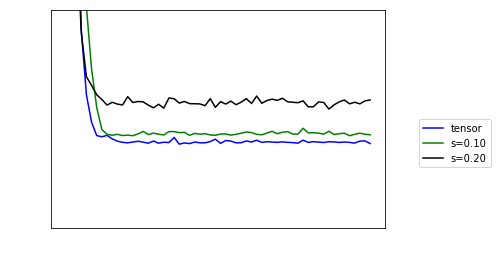

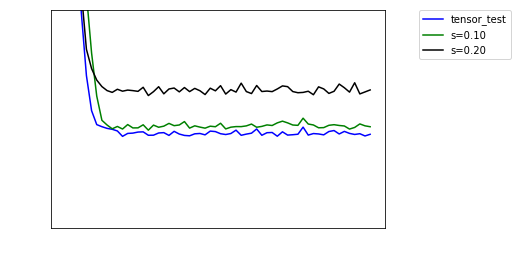

In [74]:
fig, ax1 = plt.subplots()
ax1.plot(x_e, y_tl0, 'blue', label="tensor")
# ax1.plot(x_e, y_tl, 'red', label="random")
# ax1.plot(x_e, y_tl1, 'red', label="s=0.05")
ax1.plot(x_e, y_tl2, 'green', label="s=0.10")
ax1.plot(x_e, y_tl3, 'black', label="s=0.20")
# ax1.plot(x_e, y_tl4, 'magenta', label="s=0.30")
ax1.set_xlabel('epochs', color="white")
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('training loss', color='white')
ax1.tick_params('y', colors='white')
ax1.tick_params('x', colors='white')
l1 = ax1.legend(bbox_to_anchor=(1.1 ,0.5), loc=2, borderaxespad=0.)
ax1.set_ylim([0.0,0.30])


# ax2 = ax1.twinx()
fig, ax2 = plt.subplots()
ax2.plot(x_e, acc0, 'blue', label="tensor_test")
# ax2.plot(x_e, acc, 'red', label="random_acc")
# ax2.plot(x_e, acc1, 'red',label="s=0.05")
ax2.plot(x_e, acc2, 'green',label="s=0.10")
ax2.plot(x_e, acc3, 'black',label="s=0.20")
# ax2.plot(x_e, acc4, 'magenta',label="s=0.30")
ax2.set_ylabel('test error', color='white')
ax2.tick_params('y', colors='white')
ax2.tick_params('x', colors='white')
ax2.set_xlabel('epochs', color="white")
l2 = ax2.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
ax2.set_ylim([0.0,0.30])

# fig.tight_layout()
plt.show()